In [13]:
from climpyrical.data import read_data
from climpyrical.mask import stratify_coords

from pkg_resources import resource_filename

import config

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns

In [14]:
original_model_path = resource_filename("climpyrical", "data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc")
preprocessed_model_path = resource_filename("climpyrical", "data/results/intermediate/preprocessed_models/RL50_preprocessed.nc")
reconstruction_path = resource_filename("climpyrical", "data/results/datasets/RL50_reconstructed.nc")
processed_stations_path = resource_filename('climpyrical', f'data/results/intermediate/preprocessed_stations/RL50_processed_stations.csv')
canada_shapefile_path = resource_filename("climpyrical", "data/vectors/canada_final.shp")
station_dv = "RL50 (kPa)"
name = "RL50"
output_figure_dir = resource_filename("climpyrical", "data/results/figures/")

In [15]:
model = read_data(preprocessed_model_path)
reconstruction = read_data(reconstruction_path)
df = pd.read_csv(processed_stations_path)
(dv, ) = reconstruction.data_vars
canada = gpd.read_file(canada_shapefile_path).geometry

og_model = read_data(original_model_path)
(dv_og,) = og_model.data_vars

In [16]:
if 'degC' in station_dv and not 'degC-day' in station_dv:
#     reconstruction[dv] -= 273.15
    df[station_dv] = df[station_dv] - 273.15
    model[dv] -= 273.15

In [17]:
X, Y = stratify_coords(canada)
extent = [model.rlon.min(), model.rlon.max(), model.rlat.min(), model.rlat.max()]
cxmin, cxmax, cymin, cymax = (
    canada.bounds.minx.min(),
    canada.bounds.maxx.max(),
    canada.bounds.miny.min(),
    canada.bounds.maxy.max()
)

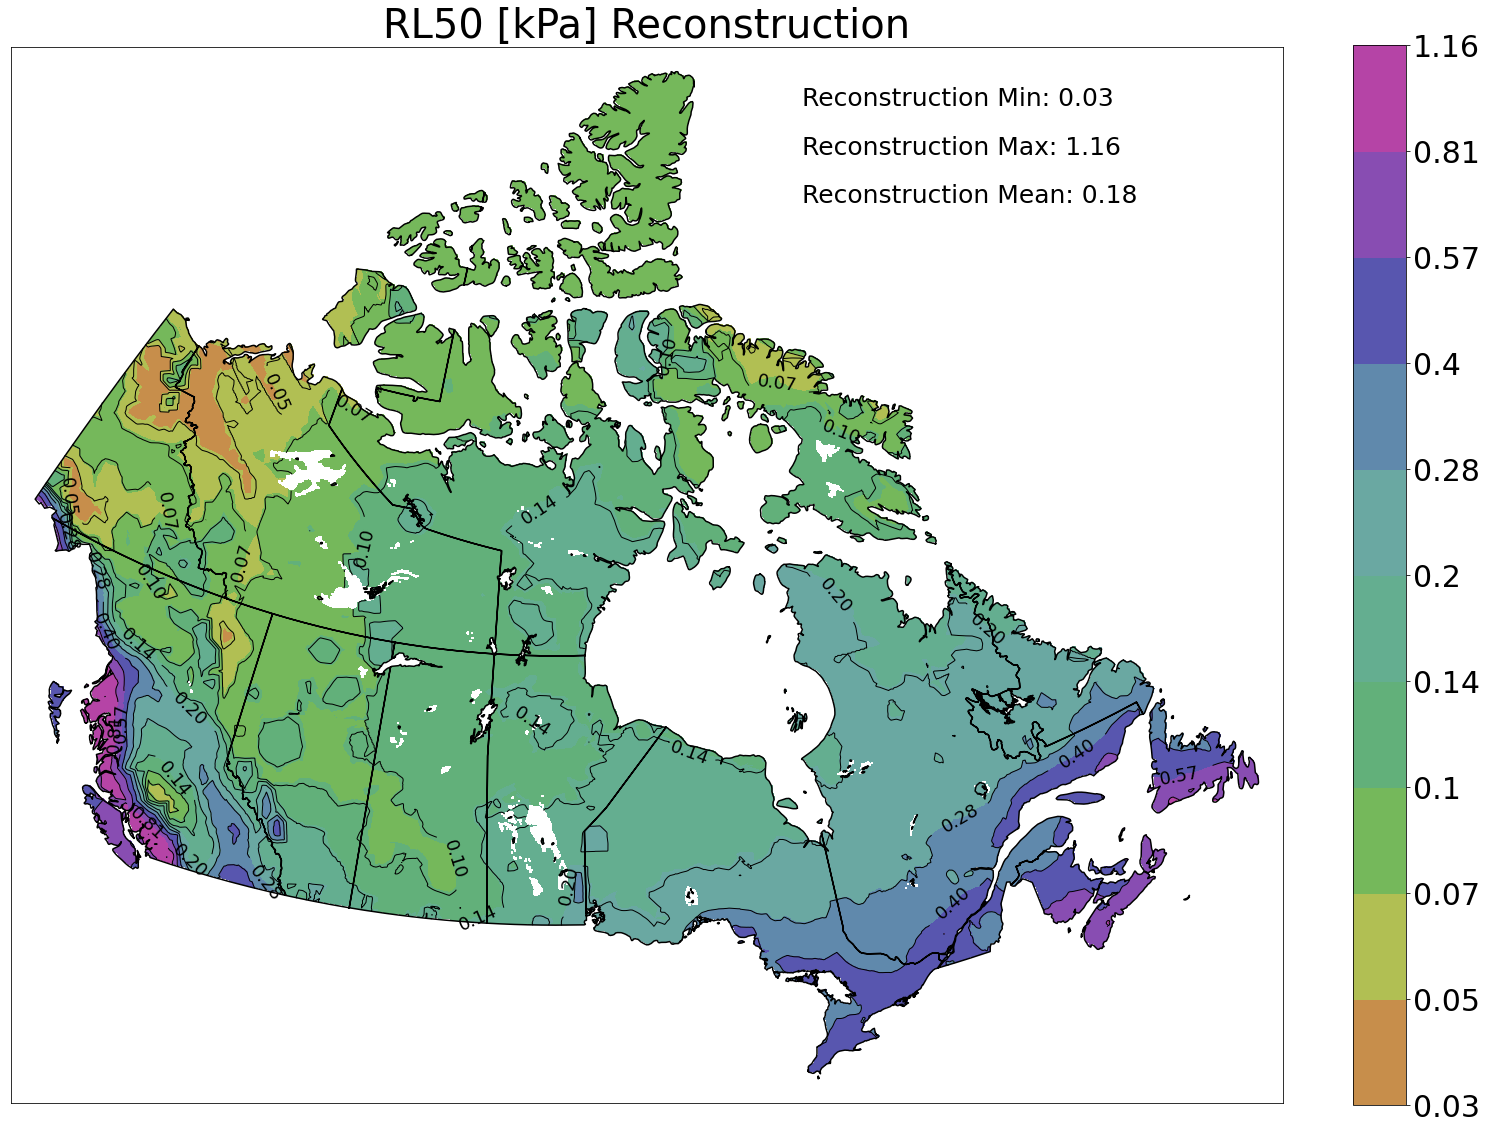

In [18]:
# each dv has particular configuration between rounding decimals and
# whether to plot on a log colorscale. This dictionary configures
# these options
plot_dict = config.plot_dict

colorscale, log, decimal = plot_dict[station_dv]
N = 10

vmin, vmax = np.nanmin(reconstruction[dv]), np.nanmax(reconstruction[dv])
fig, ax = plt.subplots(figsize=(25, 25))
if not log:
    ticks=np.round(np.linspace(vmin, vmax, N+1), decimals=decimal)
#     ticks=np.linspace(vmin, vmax, N+1)
    col1 = ax.imshow(
        reconstruction[dv], 
        origin='lower', 
        extent=extent, 
        vmin=vmin, 
        vmax=vmax, 
        cmap = matplotlib.cm.get_cmap(colorscale, N)
    )
    cbar = plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05, ticks=ticks, spacing="proportional")
    
    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

if log:
#     ticks=np.linspace(np.log10(vmin), np.log10(vmax), N+1)
    ticks=np.linspace(np.log10(vmin), np.log10(vmax), N+1)
    ticks_lin = ticks.copy()
    ticks = np.round([10**exponent for exponent in ticks], decimal)

    col1 = ax.imshow(
        np.log10(reconstruction[dv]), 
        origin='lower', 
        extent=extent, 
        vmin=ticks_lin.min(),
        vmax=ticks_lin.max(),
        cmap = matplotlib.cm.get_cmap(colorscale, N)
    )
    cbar = plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05, ticks = ticks_lin, spacing="proportional")
    
    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

CS = ax.contour(
    reconstruction.rlon,
    reconstruction.rlat,
    reconstruction[dv],
    ticks,
    colors='black',
    linewidths=1,
    zorder=4
)
ax.clabel(CS, fontsize=18, inline=1, fmt=f'%1.{decimal}f')
cbar.ax.tick_params(labelsize=30)

if decimal == 0:
    ax.text(10, 35, f'Reconstruction Min: {np.round(np.nanmin(reconstruction[dv]), decimal):.0f}', fontsize=25)
    ax.text(10, 33, f'Reconstruction Max: {np.round(np.nanmax(reconstruction[dv]), decimal):.0f}', fontsize=25)
    ax.text(10, 31, f'Reconstruction Mean: {np.round(np.nanmean(reconstruction[dv]), decimal):.0f}', fontsize=25)
else:
    ax.text(10, 35, f'Reconstruction Min: {np.round(np.nanmin(reconstruction[dv]), decimal)}', fontsize=25)
    ax.text(10, 33, f'Reconstruction Max: {np.round(np.nanmax(reconstruction[dv]), decimal)}', fontsize=25)
    ax.text(10, 31, f'Reconstruction Mean: {np.round(np.nanmean(reconstruction[dv]), decimal)}', fontsize=25)

ax.set_title(
    f'{name} [{og_model[dv_og].attrs["units"]}] Reconstruction',
    fontsize=40
)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

# Hide grid lines
ax.grid(False)


# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

ax.plot(X, Y, color='black')

plt.savefig(output_figure_dir+f'{name}_reconstruction.png')
plt.show()

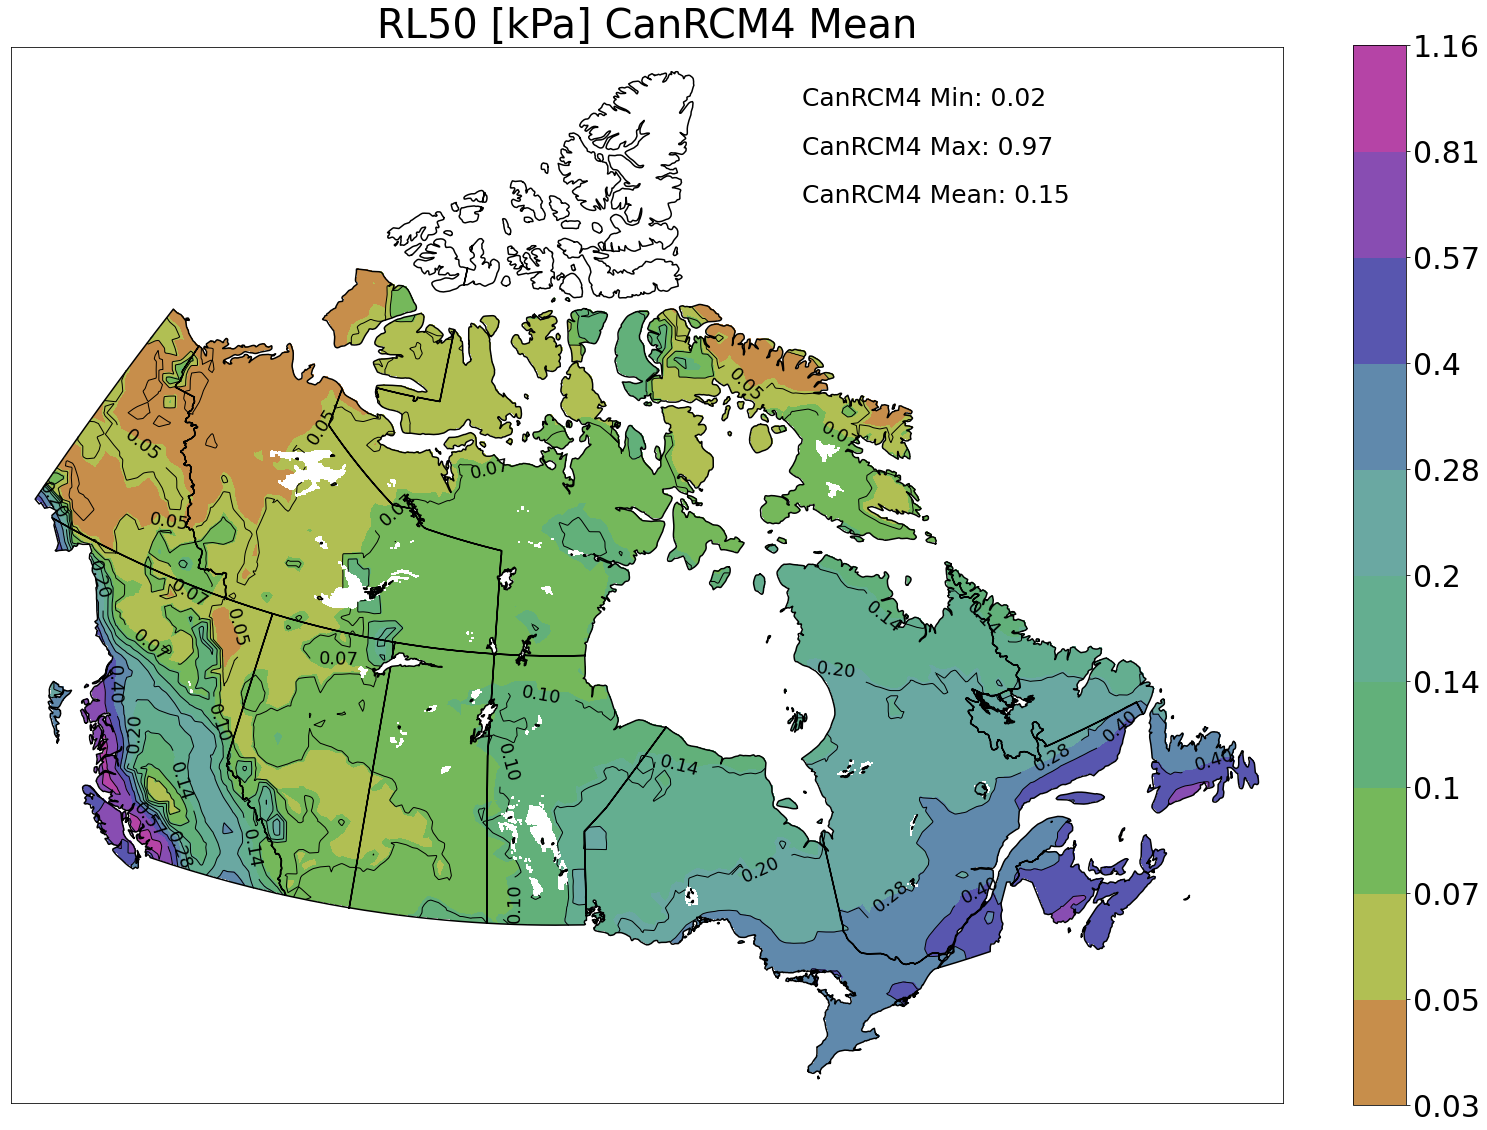

In [19]:
fig, ax = plt.subplots(figsize=(25, 25))

if not log:
    ticks=np.round(np.linspace(vmin, vmax, N+1), decimals=decimal)
#     ticks=np.linspace(vmin, vmax, N+1)
    col1 = ax.imshow(
        model[dv], 
        origin='lower', 
        extent=extent, 
        vmin=vmin, 
        vmax=vmax, 
        cmap = matplotlib.cm.get_cmap(colorscale, N)
    )
    cbar = plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05, ticks=ticks, spacing="proportional")
    
    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

if log:
#     ticks=np.linspace(np.log10(vmin), np.log10(vmax), N+1)
    ticks=np.linspace(np.log10(vmin), np.log10(vmax), N+1)
    ticks_lin = ticks.copy()
    ticks = np.round([10**exponent for exponent in ticks], decimal)

    col1 = ax.imshow(
        np.log10(model[dv]), 
        origin='lower', 
        extent=extent, 
        vmin=ticks_lin.min(),
        vmax=ticks_lin.max(),
        cmap = matplotlib.cm.get_cmap(colorscale, N)
    )
    cbar = plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05, ticks = ticks_lin, spacing="proportional")
    
    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

CS = ax.contour(
    model.rlon,
    model.rlat,
    model[dv],
    ticks,
    colors='black',
    linewidths=1,
    zorder=4
)
ax.clabel(CS, fontsize=18, inline=1, fmt=f'%1.{decimal}f')
cbar.ax.tick_params(labelsize=30)

if decimal == 0:
    ax.text(10, 35, f'CanRCM4 Min: {np.round(np.nanmin(model[dv]), decimal):.0f}', fontsize=25)
    ax.text(10, 33, f'CanRCM4 Max: {np.round(np.nanmax(model[dv]), decimal):.0f}', fontsize=25)
    ax.text(10, 31, f'CanRCM4 Mean: {np.round(np.nanmean(model[dv]), decimal):.0f}', fontsize=25)
else:
    ax.text(10, 35, f'CanRCM4 Min: {np.round(np.nanmin(model[dv]), decimal)}', fontsize=25)
    ax.text(10, 33, f'CanRCM4 Max: {np.round(np.nanmax(model[dv]), decimal)}', fontsize=25)
    ax.text(10, 31, f'CanRCM4 Mean: {np.round(np.nanmean(model[dv]), decimal)}', fontsize=25)

ax.set_title(
    f'{name} [{og_model[dv_og].attrs["units"]}] CanRCM4 Mean',
    fontsize=40
)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

# Hide grid lines
ax.grid(False)


# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

ax.plot(X, Y, color='black')
plt.savefig(output_figure_dir+f'{name}_CanRCM4_ensmean.png')
plt.show()

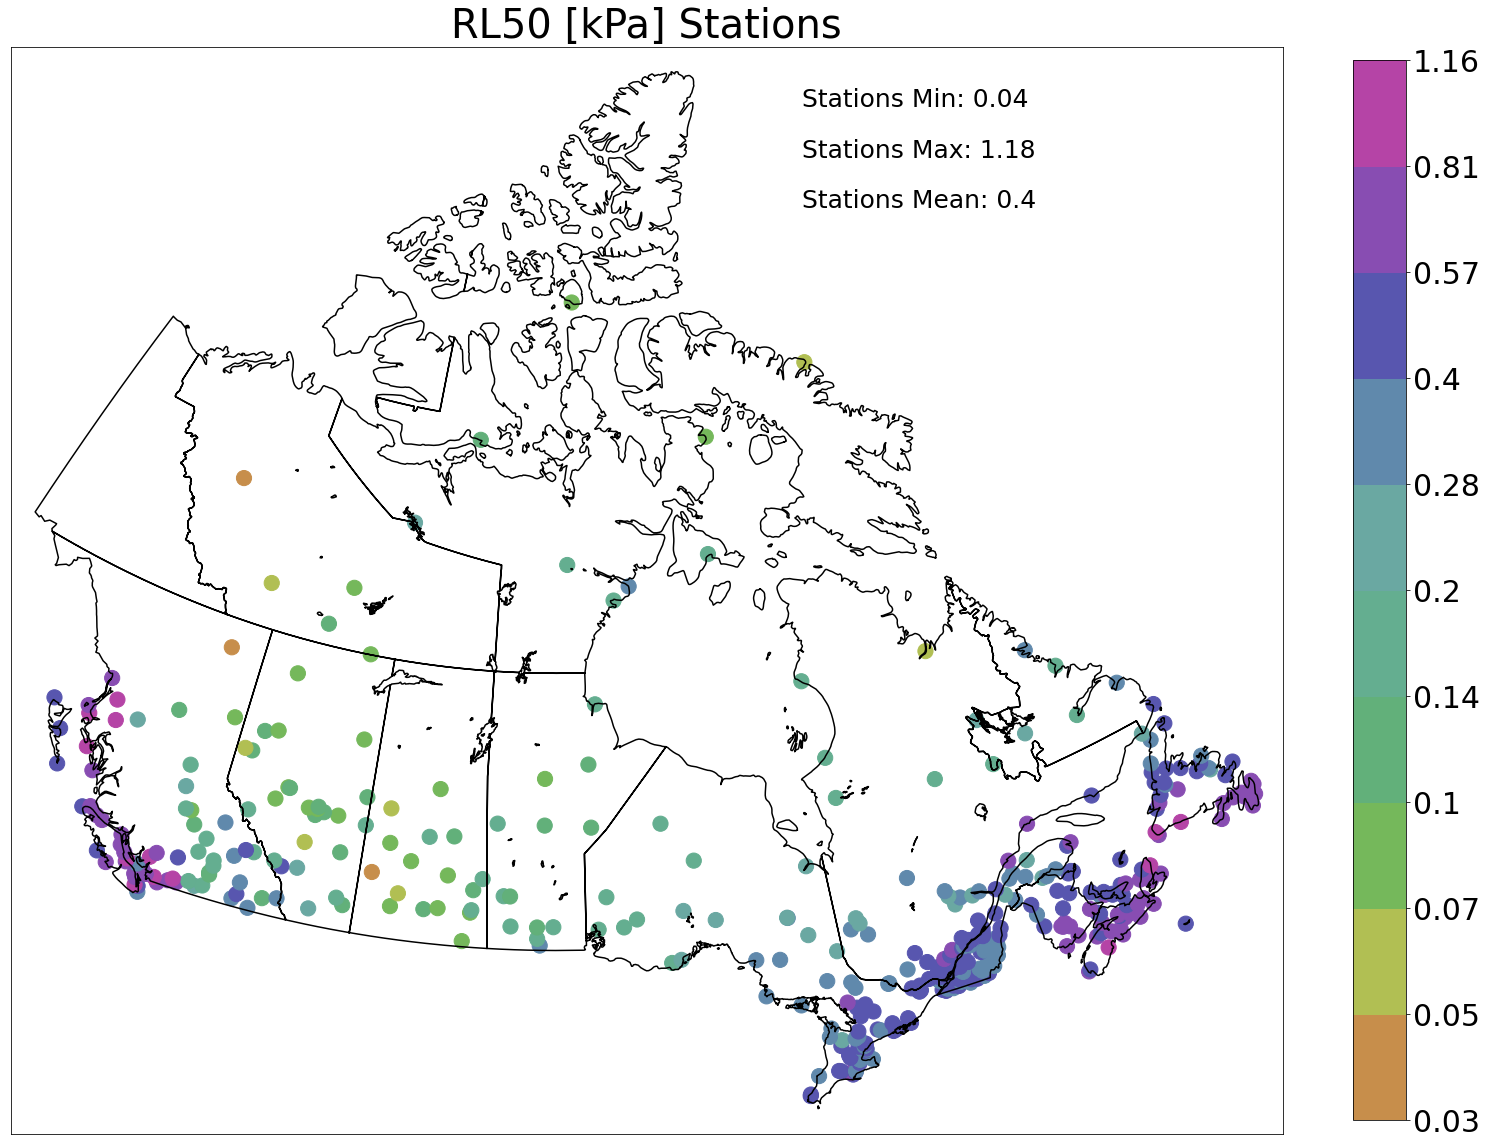

In [20]:
fig, ax = plt.subplots(figsize=(25, 20))

station_vals = df[station_dv].values

if not log:
    ticks=np.round(np.linspace(vmin, vmax, N+1), decimals=decimal)
    col1 = ax.scatter(df.rlon, df.rlat, c = station_vals, s=230, vmin = vmin, vmax = vmax, cmap = plt.cm.get_cmap(colorscale, N))
    cbar = plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05, ticks=ticks, spacing="proportional")

    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

if log:
    ticks=np.linspace(np.log10(vmin), np.log10(vmax), N+1)
    ticks_lin = ticks .copy()
    ticks = np.round([10**exponent for exponent in ticks], decimal)
    
    col1 = ax.scatter(df.rlon, df.rlat, c = np.log10(station_vals), s=230, vmin = ticks_lin.min(), vmax = ticks_lin.max(), cmap = plt.cm.get_cmap(colorscale, N))
    cbar = plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05, ticks = ticks_lin, spacing="proportional")
    
    if decimal == 0:
        cbar.ax.set_yticklabels([f'{x:.0f}' for x in ticks])
    else:
        cbar.ax.set_yticklabels([f'{x}'.format(np.round(x, decimal)) for x in ticks])

cbar.ax.tick_params(labelsize=30)

if decimal == 0:
    ax.text(10, 35, f'Stations Min: {np.round(np.nanmin(station_vals), decimal):.0f}', fontsize=25)
    ax.text(10, 33, f'Stations Max: {np.round(np.nanmax(station_vals), decimal):.0f}', fontsize=25)
    ax.text(10, 31, f'Stations Mean: {np.round(np.nanmean(station_vals), decimal):.0f}', fontsize=25)
else:
    ax.text(10, 35, f'Stations Min: {np.round(np.nanmin(station_vals), decimal)}', fontsize=25)
    ax.text(10, 33, f'Stations Max: {np.round(np.nanmax(station_vals), decimal)}', fontsize=25)
    ax.text(10, 31, f'Stations Mean: {np.round(np.nanmean(station_vals), decimal)}', fontsize=25)

    
ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

ax.set_title(f'{name} [{og_model[dv_og].attrs["units"]}] Stations', fontsize=40)
ax.plot(X, Y, color='black')
plt.savefig(output_figure_dir+f'{name}_stations.png')
plt.show()

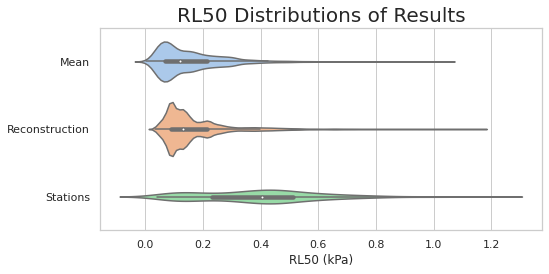

In [23]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(7, 3.5))

violindata = np.concatenate([og_model[dv_og].values.flatten(), reconstruction[dv].values.flatten(), station_vals])

means_str = ["Mean" for x in og_model[dv_og].values.flatten()]
ratio_str = ["Reconstruction" for x in reconstruction[dv].values.flatten()]
station_str = ["Stations" for x in station_vals]

vstrings = np.concatenate([means_str, ratio_str, station_str])

vdf = pd.DataFrame({station_dv: violindata, '': vstrings})
plt.tight_layout()

ax.set_title(f"{name} Distributions of Results", fontsize=20)
sns.violinplot(ax=ax, x=station_dv, y='', data=vdf, palette=sns.color_palette('pastel'))

plt.savefig(output_figure_dir+f'{name}_dist.png', bbox_inches='tight')